By Kyle M. Douglass. Downloaded from http://kmdouglass.github.io/posts/simple-pupil-function-calculations.html

*Note: This is a remake of my original post on pupil functions. I decided to write this remake to fix what I perceived to be some errors in thinking and to better address the problem of units in some of the physical quantitities. For the original, click [here](http://kmdouglass.github.io/posts/simulating-microscope-pupil-functions.html).*

A pupil function is a theoretical tool for characterizing an imaging system. In simple terms, it is a mathematical model for any general arrangement of lenses and mirrors used to collect light from an object and form an image of that object in some other plane. A few of the reasons why pupil functions are useful include:

1. they reduce a complicated optical system--such as a microscope--to a relatively simple, two-dimensional, and complex-valued function;
2. they provide a convenient way to represent the aberrations present in the system;
3. they are easy to simulate on a computer using fast Fourier transforms.

In this post I will show you how to write a simple program that computes the image of an isotropic point source of light from an optical system's pupil function.

# Theoretical background

In scalar diffraction theory, light is represented as a three-dimensional function known as the scalar field. At every point in space \\( \mathbf{r} \\), the scalar field \\( u \left( \mathbf{r} \right) \\) is a single, complex value that represents the electric field at that point. The physical laws of diffraction require that the scalar field be described by two numbers, an **amplitude** and a **phase**, that are derived from the field's real and the imaginary parts, \\( \text{Re} \left[ u \left( \mathbf{r} \right) \right] \\) and \\( \text{Im} \left[ u \left( \mathbf{r} \right) \right] \\):

\begin{align*}
A &= \sqrt{\text{Re} \left[ u \left( \mathbf{r} \right) \right]^2 + \text{Im} \left[ u \left( \mathbf{r} \right) \right]^2 } \\
\phi &= \arctan \left( \frac{\text{Im} \left[ u \left( \mathbf{r} \right) \right]}{\text{Re} \left[ u \left( \mathbf{r} \right) \right]} \right)
\end{align*}

If we know the amplitude and phase at a given point, then we know the scalar field at that point. Despite the fact that scalar diffraction theory ignores the polarization of light, it does wonderfully well at describing a large range of optical phenomena.

For most problems in imaging, we don't really need to know the three-dimensional distribution of the field in all of space. Instead, we simplify the problem by asking how an optical system transforms the field in some two-dimensional *object plane* into a new field distribution in the *image plane* (see the figure below). Any changes in scale between these two planes are caused by the system's magnification; any blurring or distortion is caused by diffraction and possibly aberrations.

![Optical system with pupils](../optical_system_with_pupils.png)

The **pupil function** is the two-dimensional Fourier transform of the scalar field in the image plane when the object is a point source emitting light equally in all directions, i.e. an *isotropic* point source. Mathematically, the pupil function is written as

\begin{equation*}
P \left(f_x, f_y \right) = \frac{1}{A}\iint_{-\infty}^{\infty} \text{PSF}_A \left( x, y \right) \exp \left[ -j 2 \pi \left( f_x x + f_y y\right) \right] \, dx \, dy
\end{equation*}

where \\( A \\) is a normalizing constant, \\( f_x \\) and \\( f_y \\) represent spatial frequencies in the x- and y-directions, and \\( j \\) is the imaginary number. \\( \text{PSF}_A \left( x, y \right) \\) is known as the **amplitude point spread function**. Despite the intimidating name, \\( \text{PSF}_A \left( x, y \right) \\) is just the scalar field from the isotropic point source in the image plane. The pupil function and the amplitude point spread function form a Fourier transform pair, so we can also write

\begin{equation*}
\text{PSF}_A \left(x, y \right) = A \iint_{-\infty}^{\infty} P \left( f_x, f_y \right) \exp \left[ j 2 \pi \left( f_x x + f_y y\right) \right] \, df_x \, df_y
\end{equation*}

What all of this means is that we can compute the image of an on-axis, isotropic point source if we know the pupil function that describes the system: compute the two-dimensional Fourier transform of the pupil function and voilà, you have the image (or at least the field that will form the image).

## The pupil punction is dimensionless; \\( \text{PSF}_A \\) is a field

By convention the pupil function is a dimensionless complex number and has a magnitude between 0 and 1. The amplitude PSF, however, has units of electric field, or Volts per distance, \\( V / m \\).

If you perform a dimensional analysis on the Fourier transform expressions above, you can see that the normalizing constant \\( A \\) has to have units of \\( V \times m \\). For example, if \\( \text{PSF}_A \\) has units of \\( V / m \\) and \\( dx \\) and \\( dy \\) both have units of \\( m \\), then \\( A \\) has units of \\( V \times m \\) and the pupil function is therefore dimensionless. Sometimes in the literature you will find that units or a normalizing constant are ignored or, worse, that the reader can sort of "fill them in" later. I prefer to be explicit and to define the \\( \text{PSF}_A \\) to be a field.

## Pupil functions are not entrance or exit pupils

The pupil function and the pupil planes of a system are not the same thing. The entrance and exit pupils--which together are known as the pupil planes--are the planes in which the images of the system's [aperture stop](http://hyperphysics.phy-astr.gsu.edu/hbase/geoopt/stop.html) are located. The pupil function, however, is not an image of the aperture stop of the system; it's a 2D Fourier transform of a field.

There is never-the-less a relationship between the pupil function and the plane of the exit pupil. The pupil function represents the relative amplitude and phase of the field on the surface of a so-called [reference sphere](http://www.optics4kids.org/home/content/what-is-optics/refraction/aberrations/) that intersects the optics axis in the plane of the system's exit pupil.

# Pupil function simulations in python

The goal of this simulation will be simple: given a pupil function, a single wavelength, an optical system with a numerical aperture NA, and an amount of power that passes through the image plane, compute the image of an on-axis isotropic point source.

There are only a few steps needed to achieve our goal:

1. define the simulation's input parameters;
2. setup the image plane and pupil plane coordinate system;
3. create the pupil plane and normalize it so that the field carries the desired amount of power;
4. and compute the field in the image plane.

Before we go further, it's worth pointing out that the pupil function and \\( \text{PSF}_A \\) are obtained by calculating the **continuous Fourier transform** of one another. On a computer, however, it's often easiest to compute what's called a discrete Fourier tranform via the **fast Fourier transform (FFT)** algorithm. [The continuous Fourier transform and the FFT are not, strictly speaking, the same thing](http://blogs.mathworks.com/steve/2010/03/15/the-dft-and-the-dtft-mathjax/). Therefore, we should expect from the start that there may be small differences between the computed \\( \text{PSF}_A \\) and the analytical calculation.

With this in mind, we'll start by importing a few scientific libraries like Numpy and Scipy.

In [1]:
%pylab inline
import sys
from numpy.fft import fft2, fftshift
import scipy
from scipy.integrate import simps
import seaborn as sns # Used only to set up plots
sns.set_context(context = 'talk')
plt.style.use('dark_background')
plt.rcParams['figure.facecolor'] = '#272b30'
plt.rcParams['image.cmap'] = 'viridis' 

print('Python version:\n{}\n'.format(sys.version))
print('Numpy version:\t\t{}'.format(np.__version__))
print('matplotlib version:\t{}'.format(matplotlib.__version__))
print('Scipy version:\t\t{}'.format(scipy.__version__))
print('Seaborn version:\t{}'.format(sns.__version__))

Populating the interactive namespace from numpy and matplotlib
Python version:
3.5.5 |Anaconda custom (64-bit)| (default, Mar 12 2018, 23:12:44) 
[GCC 7.2.0]

Numpy version:		1.14.4
matplotlib version:	2.2.2
Scipy version:		1.1.0
Seaborn version:	0.8.1


# Step 1: Define the input parameters

Next, we need to define a few parameters that will determine the output of the simulations. These parameters are:

1. **wavelength** Units are \\( \mu m \\).
2. **NA** Numerical aperture of the system. No units.
3. **pixelSize** The length of a square pixel in the object space. Units are \\( \mu m \\).
4. **numPixels** The number of pixels in your camera. This will be assumed to be even.
5. **power** The total power carried by the field in Watts, \\( W \\).

Note that pixel size is defined as the size of a pixel in the *object space*. Defining it like this is often more intuitive than defining the pixel size in the image space. For example, when you see a scale bar on a microscopy image, the distances correspond to object space distances, not the actual distance that the image spans on the piece of paper or computer screen. Furthermore, there is no problem with working with an object space pixel size in the image plane since the coordinate systems in the object and image planes of our perfect optical system can be easily mapped onto one another by a linear scaling by the system's magnification.

We don't neccessarily need to use a camera as the detector. Since we are limited to working with discrete arrays in the computer, though, it's convenient to say that we have a camera as a detector since each pixel is a discrete sample of the field.

In addition to the above parameters, we'll assume that the object, the imaging system, and the image plane are all in air. We'll define a constant \\( Z_0 = 376.73 \, \Omega \\) which is known as the [impedance of free space](https://en.wikipedia.org/wiki/Wave_impedance) or the vacuum impedance. This is the constant of proportionality between the power carried by the scalar field and the integral of its absolute square in the image plane:

\begin{equation*}
P_0 = \frac{1}{Z_0} \iint_{-\infty}^{\infty} \left| \text{PSF}_A \left( x, y \right) \right|^2 \, dx \, dy
\end{equation*}

Of course, air does not really have the same impedance as vacuum, but the two values are close enough. I have also used \\( P_0 \\) to denote the power because I already used \\( P \left( f_x, f_y \right) \\) to denote the pupil function.

In [2]:
# Setup the simulation parameters
wavelength = 0.68   # microns
NA         = 0.7    # Numerical aperture of the objective
pixelSize  = 0.1    # microns
numPixels  = 2048   # Number of pixels in the camera; keep this even
power      = 0.1    # Watts
Z0         = 376.73 # Ohms; impedance of free space

# Step 2: Create the image and pupil plane coordinate systems

Our simulation will transform the values in a two-dimensional square array of complex numbers (the pupil function) into a new two-dimensional array of complex numbers of the same size. Before we do this, however, let's first determine the coordinates of each pixel.

Since we specified the pixel size and the number of pixels, it's easiest to start with the image plane coordinates. We will define the origin of our coordinate system to lie at the center of the array, which, for an even number of pixels and array indexes that start at zero, lies halfway between the pixels \\( \left( \frac{\text{numPixels}}{2} \right) - 1 \\) and \\( \left( \frac{\text{numPixels}}{2} \right) \\) in both the horizontal and vertical directions.

In [3]:
# Create the image plane coordinates
x = np.linspace(-pixelSize * numPixels / 2, pixelSize * numPixels / 2, num = numPixels, endpoint = True)

We only need to create a single, one-dimensional array to represent the coordinates because our image and pupil plane arrays will be square; we can use the same array to represent the coordinates in both the horizontal and vertical directions.

With the image plane coordinates taken care of, the next question is: what are the pupil plane coordinates? This question is a frequent source of frustration for students (and full-time scientists). I won't go into the details in this post, but instead will just tell you the two rules you need to remember for Fourier optics simulations

1. The number of elements in the pupil function array is the same as the number of elements in the image plane array.
2. For an even number of array elements, the frequency values along either principle direction in the pupil function run from \\( -\frac{f_S}{2} \\) to \\( f_S \left( \frac{1}{2} - \frac{1}{\text{numPixels}} \right) \\) with the spacing between discrete coordinate values equal to \\( \frac{f_S}{\text{numPixels}} \\).

\\( f_S \\) is called the sampling frequency and is equal to one divided by the spacing between image space coordinates. We can go ahead now and compute the frequency-space coordinate values.

In [4]:
# Create the Fourier plane
dx = x[1] - x[0]    # Sampling period, microns
fS = 1 / dx         # Spatial sampling frequency, inverse microns
df = fS / numPixels # Spacing between discrete frequency coordinates, inverse microns
fx = np.arange(-fS / 2, fS / 2, step = df) # Spatial frequency, inverse microns

# Step 3: Create the pupil function

In nearly all imaging systems, the pupil is circular because its optical elements are circular. The radius of the pupil function is the ratio of the system's numerical aperture to the wavelength of the light, \\( \frac{\text{NA}}{\lambda} \\) ([Hanser, 2004](http://onlinelibrary.wiley.com/doi/10.1111/j.0022-2720.2004.01393.x/full)). Perfect systems like the one we are modeling here have a pupil with a constant value everywhere inside this circle and zero outside of it.

We can simulate such a pupil by making a circular mask with a radius of \\( \frac{\text{NA}}{\lambda} \\). The mask is one inside the circle and zero outside of it. 

In [5]:
# Create the pupil, which is defined by the numerical aperture
fNA             = NA / wavelength # radius of the pupil, inverse microns
pupilRadius     = fNA / df        # pixels
pupilCenter     = numPixels / 2   # assumes numPixels is even
W, H            = np.meshgrid(np.arange(0, numPixels), np.arange(0, numPixels)) # coordinates of the array indexes
pupilMask       = np.sqrt((W - pupilCenter)**2 + (H - pupilCenter)**2) <= pupilRadius

## Define the power carried by the scalar field

I mentioned in the theoretical background above that the total optical power carried by the field is the two dimensional integral of the absolute square of the field divided by the impedance. If we want to set the power as an input of the simulation, we need to first normalize our pupil values by this integral.

[Parseval's theorem](https://en.wikipedia.org/wiki/Parseval's_theorem) tells us that we can integrate over \\( \text{PSF}_A \left( x, y \right) \\) and \\( A \times P \left( f_x, f_y \right) \\), i.e. the image plane field or the normalized pupil, respectively, and get the same number:

\begin{equation*}
\iint_{-\infty}^{\infty} \left| \text{PSF}_A \left( x, y \right) \right|^2 \, dx \, dy = A^2 \iint_{-\infty}^{\infty} \left| P \left( f_x, f_y \right) \right|^2 \, df_x \, df_y
\end{equation*}

Now that we have the pupil, we can perform a numerical integration over it using Simpson's rule to find the normalizing constant. We then multiply the pupil by the square root of this constant times our desired value for the power to set the total power carried by the field.

In [6]:
# Compute normalizing constant
norm_factor = simps(simps(np.abs(pupilMask)**2, dx = df), dx = df) / Z0 # A^2
print('Normalization constant:\t\t{:.4f} W'.format(np.sqrt(norm_factor)))

# Renormalize the pupil values
pupil = pupilMask * (1 + 0j)
normedPupil = pupil * np.sqrt(power / norm_factor)

new_power = simps(simps(np.abs(normedPupil)**2, dx = df), dx = df) / Z0
print('User-defined power:\t\t{:.4f} W'.format(power))
print('Power now carried by field:\t{:.4f} W'.format(new_power))

Normalization constant:		0.0940 W
User-defined power:		0.1000 W
Power now carried by field:	0.1000 W


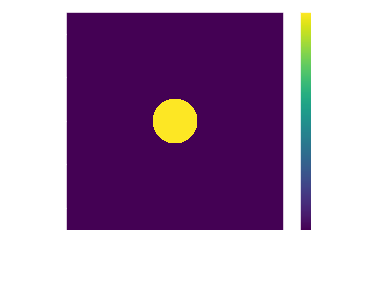

Power in pupil plane: 0.1000 W


In [7]:
# Show the pupil
ax = plt.imshow(np.abs(pupil), extent = [fx[0], fx[-1], fx[0], fx[-1]])
plt.grid(False)
cb = plt.colorbar(ax)
cb.set_label('$P \, ( f_x, f_y ) $')
plt.xlabel('$f_x$, $\mu m^{-1}$')
plt.ylabel('$f_y$, $\mu m^{-1}$')
plt.show()

# Compute the power
power_pupil = simps(simps(np.abs(normedPupil)**2, dx = df), dx = df) / Z0
print('Power in pupil plane: {:.4f} W'.format(power_pupil))

# Step 4: Compute the image of the point source

With the pupil and coordinate systems established, we are now ready to compute the image of the isotropic point source that this system produces.

To do this, we need to perform a few easy but important steps. In the first step, we will shift the origin of the pupil from the center of the array to the array indexes \\( \left( 0, 0 \right) \\) using the `ifftshift()` function. The reason we do this is that `fft2()` expects that the zero frequency value lies at the origin of the array. The two-dimensional FFT of the shifted pupil is then computed, producing a new array with the zero frequency at array indexes \\( \left( 0, 0 \right) \\) and the Nyquist frequency \\( f_S / 2 \\) in the middle of the array's axes ([numpy.fft.fft2 - NumPy v1.11 Manual, accessed on 2016-11-15](https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft2.html)). We finish by shifting the origin back to the center of the array using `fftshift()` so that it makes sense when we visualize the results.

The final step is to multiply the result by the square of the spacing between frequency coordinates. This step ensures that the power is preserved during the FFT operation ([Schmidt, 2010, pp. 15-18](http://spie.org/Publications/Book/866274)).

Chaining the functions together, these steps look like:

```python
psf_a = fftshift(fft2(ifftshift(normedPupil))) * df**2
```

The image is the [irradiance](https://en.wikipedia.org/wiki/Irradiance) in the image plane, which is the absolute square of the field, divided by the vacuum impedance. Its units are power per area, or in this case \\( W / \mu m^2 \\). In optics, the irradiance is what is measured by a camera, not the field.

```python
image = np.abs(psf_a)**2 / Z0
```

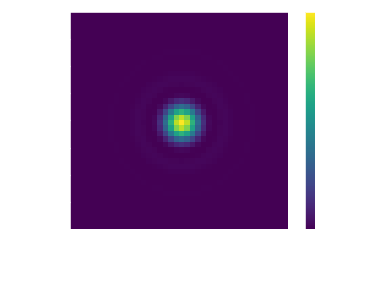

In [8]:
psf_a = fftshift(fft2(ifftshift(normedPupil))) * df**2
image = np.abs(psf_a)**2 / Z0

# Show the image plane
img = plt.imshow(image, interpolation='nearest', extent = [x[0], x[-1], x[0], x[-1]])
cb = plt.colorbar(img)
plt.gca().set_xlim((-2, 2))
plt.gca().set_ylim((-2, 2))

plt.xlabel('x, $\mu m$')
plt.ylabel('y, $\mu m$')
cb.set_label('Irradiance, $W / \mu m^2$')
plt.grid(False)
plt.show()

Above you can see the image of an isotropic point source. The image is not a point but rather a blurred spot in the center of the image plane due to diffraction at the pupil.

# Verify the results

The first thing we can do to check whether the above result is correct is compute the power over the image above. By Parseval's theorem, it should be the same as the integral of the normalized pupil function divided by the vacuum impedance.

In [9]:
power_image = simps(simps(image, dx = dx), dx = dx)
print('Power in pupil plane: {:.4f} W'.format(power_pupil))
print('Power in object plane: {:.4f} W'.format(power_image))

Power in pupil plane: 0.1000 W
Power in object plane: 0.1000 W


So far so good. The next thing that we can do to verify these results is to calculate the sampled values of the analytical solution to this problem. Scalar diffraction theory predicts that the solution for the irradiance of the field diffracted by a circular aperture is an [Airy disk](https://en.wikipedia.org/wiki/Airy_disk):

\begin{equation*}
I \left( r \right) = I_0 \left[ \frac{2 J_1 \left( X \right)}{X} \right]^2
\end{equation*}

where \\(X = \frac{2 \pi r \, \text{NA}}{\lambda} \\), \\( r = \sqrt{x^2 + y^2} \\) is the radial coordinate, and \\( J_1 \left( r \right) \\) is called the first-order Bessel function of the first kind ([Weisstein, Mathworld, accessed on 2016-11-16](https://en.wikipedia.org/wiki/Irradiance)). This function does not exist inside Python's scientific libraries, so we will need to create it.

In [10]:
from scipy.special import j1 as bessel1
def airyDisk(x,y, NA = 0.5, wavelength = 0.532):
    """Computes a 2D airy disk pattern.
    
    Parameters
    ----------
    x, y : array of int, array of int
        Coordinates where the function will be evaluated.
    NA   : float
        The system's numerical aperture.
    wavelength: float
        The wavelength of the light; same units as x and y.
        
    Returns
    -------
    result : array of float
        
    """
    r      = np.sqrt(x**2 + y**2)
    X      = 2 * np.pi * r * NA / wavelength
    result = (2 * bessel1(X) / X)**2
    
    try:
        # Replace value where divide-by-zero occurred with 1
        result[np.logical_or(np.isinf(result), np.isnan(result))] = 1
    except TypeError:
        # TypeError is thrown when single integers--not arrays--are passed into the function
        result = np.array([result])
        result[np.logical_or(np.isinf(result), np.isnan(result))] = 1
    
    return result

Now we can go ahead and visually compare our image plane calculations with the airy disk. If we subtract one from the other, we should get all zeros.

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

/groups/turaga/home/turagas/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in true_divide


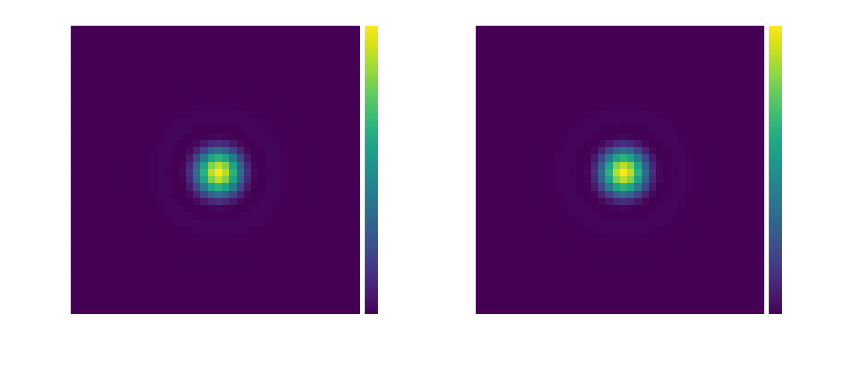

In [12]:
# Subtraction by dx/2 places the origin at the edge of a pixel, not a center
X, Y = np.meshgrid(x - dx/2, x - dx / 2, indexing = 'xy')

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 8))

img = ax[0].imshow(image, interpolation='nearest', extent = [x[0], x[-1], x[0], x[-1]])

divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cb0 = plt.colorbar(img, cax = cax)

ax[0].grid(False)
ax[0].set_xlim((-2, 2))
ax[0].set_ylim((-2, 2))

ax[0].set_xlabel('x, $\mu m$')
ax[0].set_ylabel('y, $\mu m$')
ax[0].set_title('Simulation')
plt.grid(False)

I0  = np.max(image)
img = ax[1].imshow(I0 * airyDisk(X,Y, NA = NA, wavelength = wavelength), interpolation = 'nearest', extent = [x[0], x[-1], x[0], x[-1]])

divider = make_axes_locatable(ax[1])
cax  = divider.append_axes("right", size="5%", pad=0.05)
cb1  = plt.colorbar(img, cax = cax)

ax[1].grid(False)
ax[1].set_xlim((-2, 2))
ax[1].set_ylim((-2, 2))

ax[1].set_xlabel('x, $\mu m$')
ax[1].set_title('Theory')

cb1.set_label('Irradiance, $W / \mu m^2$')

plt.tight_layout()
plt.show()

/groups/turaga/home/turagas/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in true_divide


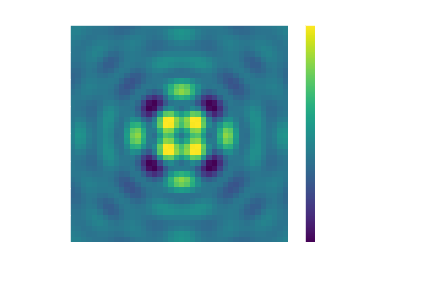

In [13]:
# Find and plot the difference between the simulated image and the theoretical one
I0 = np.max(image)
diffImg = image - I0 * airyDisk(X,Y, NA = NA, wavelength = wavelength)

plt.imshow(diffImg, interpolation = 'nearest', extent = [x[0], x[-1], x[0], x[-1]])
cb = plt.colorbar()
cb.set_label('Irradiance, $W / \mu m^2$')
plt.grid(False)
plt.xlabel('x $\mu m$')
plt.xlim((-2, 2))
plt.ylabel('y $\mu m$')
plt.ylim((-2, 2))
plt.title('Difference between simulation and theory')
plt.show()

From the plots above you can see that the simulations perform pretty well at finding the image of the point source. In fact, the differences in the final irradiance values differ by at most a small fraction of a percent.

However, the pattern in the difference image is not random, so these differences are probably not round-off errors. In fact, they come from the minor but important detail that we are calculating a discrete Fourier transform with the FFT command, whereas the theory predicts that the point spread function is a continuous Fourier transform of the pupil.

# Final remarks

The calculations I discussed here rely on quite a few simplifying assumptions. The first is that they are based on scalar diffraction theory. The real electromagnetic field is polarized and is described not by a scalar but by a three dimensional, complex-valued vector. The theory of vector diffraction describes how such a field propagates through an optical system; naturally, it is more complicated than scalar diffraction theory.

Isotropic point sources are also an idealization of reality. Single fluorescent molecules, for instance, do not emit light equally in all directions but rather in a pattern known as [dipole radiation](https://www.youtube.com/watch?v=Lx7LNVtQvTs).

Finally, the optical system as modeled here was a linear, shift-invariant system. This means that the same pupil function can actually be used to compute the image of any off-axis point source as well; we would only need to apply a linear phase ramp to the pupil to account for this. Real optical systems are only approximatley linear and shift-invariant, which means that a more complete model would assign a different pupil function to each object point. This then allows for aberrations that vary as a function of object position, but requires more information to fully describe the system.